<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#(1)-Data-loading" data-toc-modified-id="(1)-Data-loading-1">(1) Data loading</a></span></li><li><span><a href="#(2)-Off-Policy-Learning" data-toc-modified-id="(2)-Off-Policy-Learning-2">(2) Off-Policy Learning</a></span></li><li><span><a href="#(3)-Off-Policy-Evaluation" data-toc-modified-id="(3)-Off-Policy-Evaluation-3">(3) Off-Policy Evaluation</a></span></li></ul></div>

- https://github.com/st-tech/zr-obp 

In [7]:
from obp.dataset import OpenBanditDataset
from obp.policy import BernoulliTS
from obp.ope import OffPolicyEvaluation, InverseProbabilityWeighting as IPW

from pathlib import Path
import pandas as pd
import os

In [48]:
from datetime import timedelta

# (1) Data loading

In [87]:
base_path = Path('.')
bts_women = base_path / 'bts/women'
item_context_path = bts_women / 'item_context.csv'
women_path = bts_women / 'women.csv'

In [88]:
item_context = pd.read_csv(item_context_path, index_col=0)
women = pd.read_csv(women_path, index_col=0, nrows=70_000)

In [89]:
item_context.shape, women.shape

((46, 5), (70000, 55))

In [90]:
women.head()

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_36,user-item_affinity_37,user-item_affinity_38,user-item_affinity_39,user-item_affinity_40,user-item_affinity_41,user-item_affinity_42,user-item_affinity_43,user-item_affinity_44,user-item_affinity_45
0,2019-11-24 00:00:00.110777+00:00,12,1,0,0.029985,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,7bc94a2da491829b777c49c4b5e480f2,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-11-24 00:00:00.111897+00:00,38,3,0,0.084535,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,7bc94a2da491829b777c49c4b5e480f2,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-11-24 00:00:00.112501+00:00,36,2,0,0.241770,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,7bc94a2da491829b777c49c4b5e480f2,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-11-24 00:00:00.398533+00:00,36,2,0,0.241770,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,9f4e8271d3d3014af5f35124c2de5082,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-11-24 00:00:00.398533+00:00,44,1,0,0.015315,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,9f4e8271d3d3014af5f35124c2de5082,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
women['timestamp'] = pd.to_datetime(women['timestamp'])
women['lag_timestamp'] = women['timestamp'].shift(1)
women['diff'] = women['timestamp'] - women['lag_timestamp']

women['group'] = women['diff'] > timedelta(milliseconds=5)
women['group'] = women['group'].cumsum()

columns = women.columns.to_list()
columns = columns[-1:] + columns[:-1]
women = women[columns]

In [106]:
women['group'].max()

25735

In [98]:
women['position'].value_counts()

2    23342
1    23329
3    23329
Name: position, dtype: int64

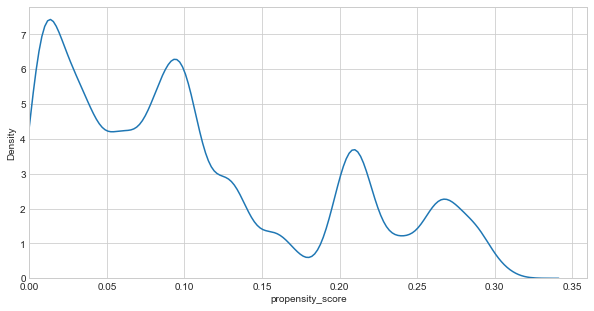

In [107]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize = (10,5))
sns.kdeplot(women['propensity_score'], ax = ax).set(xlim=(0))
plt.show()

In [31]:
item_context.head()

,item_id,item_feature_0,item_feature_1,item_feature_2,item_feature_3
0,0,-0.370106,cf6b1dd93a6678b01f1cb867355ecb02,54c2f1abb60b37635be8dbc01f3f374f,5aeba6930d398e792dfb07fdd0574f8a
1,1,0.525196,1aad13dfd0d65bfa2491918c745bc285,fcb8dceb32d4a17abeb852bfb9b81e9d,ea42d32e337404227d803bfe5d3d5f69
2,2,-0.134500,ff384b17008335703e4842e33c0f0820,54c2f1abb60b37635be8dbc01f3f374f,5aeba6930d398e792dfb07fdd0574f8a
3,3,-0.535030,cf6b1dd93a6678b01f1cb867355ecb02,ed8f0cc18effabd1b01b60586ccb2dab,5aeba6930d398e792dfb07fdd0574f8a
4,4,-0.252303,1aad13dfd0d65bfa2491918c745bc285,19dac1ee0a001749205504d8dc867884,a06874cb4431b6b70642db73b4a95562


In [26]:
item_popular = women.groupby('item_id')['click'].agg(['sum', 'count'])
item_popular['ctr'] = item_popular['sum'] / item_popular['count']

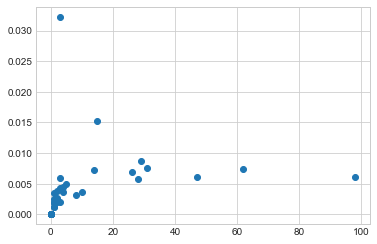

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

plt.scatter(item_popular['sum'], item_popular['ctr'])